## Outliers

An outlier is an observation that lies outside the overall pattern of a distribution __[Moore and McCabe, 1999]__.

- Outliers can either be treated special completely ignored 

- E.g., Fraudulant transactions are outliers, but since we want to avoid them, they must be paid special attention 

- If we think that the outliers are errors, we should remove them 


## Which of the ML models care about Outliers?

Affected models: 

- AdaBoost 
- Linear models
- Linear regression
- Neural Networks (if the number is high)
- Logistic regression 
- KMeans
- Heirarchical Clustering 
- PCA

Unaffected models:

- Decision trees
- Naive bayes
- SVMs
- Random forest 
- Gradient boosted trees 
- K-Nearest Neighbors


### Identification

- Extreme Value Analysis
  - IQR = 75th quantile - 25th quantile
  - Upper boundary = 75th quantile + (IQR * 1.5)
  - Lower boundary = 25th quantile - (IQR * 1.5)
  - Upper Extreme boundary = 75th quantile + (IQR * 3)
  - Lower Extreme boundary = 25th quantile - (IQR * 3)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/FeatureEngineering/train_date.csv")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
data.head()

,Date,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,12/6/2019,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,12/7/2019,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,12/8/2019,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,12/9/2019,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,12/10/2019,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


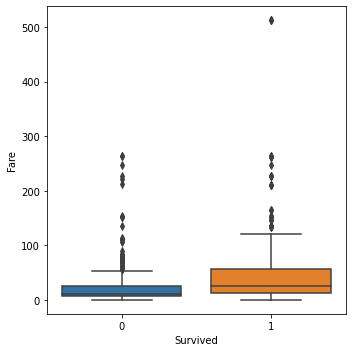

In [4]:
# Outliers according to the quantiles + 1.5 IQR 
sns.catplot(x="Survived", y="Fare", kind="box", data=data)
sns.despine(left=False, right=False, top=False)

In [5]:
data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [6]:
# Get outliers
IQR = data['Fare'].quantile(0.75) - data['Fare'].quantile(0.25)
ub = data['Fare'].quantile(0.75) + (IQR * 3)
lb = data['Fare'].quantile(0.25) - (IQR * 3)
data[(data['Fare']>ub) | (data['Fare']<lb)].groupby('Survived')['Fare'].count()

Survived
0    14
1    39
Name: Fare, dtype: int64

Text(0, 0.5, '#')

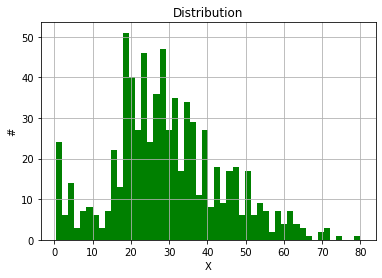

In [7]:
# First let's plot the histogram to get an idea of the distribution
fig = data.Age.hist(bins=50, color='green')
fig.set_title('Distribution')
fig.set_xlabel('X')
fig.set_ylabel('#')

In [8]:
# Get outliers
IQR = data['Age'].quantile(0.75) - data['Age'].quantile(0.25)
ub = data['Age'].mean() + data['Age'].std()
lb = data['Age'].mean() - data['Age'].std()
data[(data['Age']>ub) | (data['Age']<lb)].groupby('Survived')['Age'].count()

Survived
0    106
1     92
Name: Age, dtype: int64

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [0]:
data = data.drop(['Date'], axis=1)

In [11]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [12]:
data[['Fare','Age']].isnull().mean()

Fare    0.000000
Age     0.198653
dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data[['Age', 'Fare']].fillna(0),
                                                    data['Survived'],
                                                    test_size=0.2)
X_train.shape, X_test.shape

((712, 2), (179, 2))

In [0]:
# We will cap the values of outliers 
data_processed = data.copy()

_temp = np.ceil(data['Age'].mean() + data['Age'].std())
data_processed.loc[data_processed.Age >= _temp, 'Age'] = _temp

IQR = data['Fare'].quantile(0.75) - data['Fare'].quantile(0.25)
_temp = np.ceil(data['Fare'].quantile(0.75) + (IQR * 3))
data_processed.loc[data_processed.Fare > _temp, 'Fare'] = _temp

X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(
    data_processed[['Age', 'Fare']].fillna(0),
    data_processed['Survived'],
    test_size=0.2)

In [15]:
from sklearn.cluster import DBSCAN

df_outliers = data.copy()
df_outliers = df_outliers.fillna(0)

column_name = 'Fare'
obj = DBSCAN()
_temp = obj.fit_predict(df_outliers[[column_name]])
print(np.unique(_temp, return_counts=True))
central = df_outliers[_temp==1][column_name].mean()
max_val = df_outliers[_temp==1][column_name].max()
min_val = df_outliers[_temp==1][column_name].min()
df_outliers.loc[_temp==-1,[column_name]] = df_outliers.loc[_temp==-1,[column_name]].apply(lambda x: [max_val if y > central else y for y in x])
df_outliers.loc[_temp==-1,[column_name]] = df_outliers.loc[_temp==-1,[column_name]].apply(lambda x: [min_val if y < central else y for y in x])
print(data.shape)
print(df_outliers.shape)

column_name = 'Age'
obj = DBSCAN()
_temp = obj.fit_predict(df_outliers[[column_name]])
print(np.unique(_temp, return_counts=True))
central = df_outliers[_temp==1][column_name].mean()
max_val = df_outliers[_temp==1][column_name].max()
min_val = df_outliers[_temp==1][column_name].min()
df_outliers.loc[_temp==-1,[column_name]] = df_outliers.loc[_temp==-1,[column_name]].apply(lambda x: [max_val if y > central else y for y in x])
df_outliers.loc[_temp==-1,[column_name]] = df_outliers.loc[_temp==-1,[column_name]].apply(lambda x: [min_val if y < central else y for y in x])
print(data.shape)
print(df_outliers.shape)

X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(
    df_outliers[['Age', 'Fare']],
    df_outliers['Survived'],
    test_size=0.2)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24]), array([105, 347,   5,  10,  32, 130,  32,  67,   9,   6,  11,  15,  15,
         7,  11,   5,   5,  11,  13,  10,   9,  15,   5,   5,   5,   6]))
(891, 12)
(891, 12)
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36]), array([ 49,  27,  11,  18,  34, 191,   8,  10,  18,  12,  10,   5,  40,
        14,  44,  47,  25,  21,  13,  26,   6,   6,  17,  13,  35,  17,
        70,  29,   9,   5,   8,   7,   7,   9,  10,   6,   5,   9]))
(891, 12)
(891, 12)


In [16]:
print(X_train.shape)
print(X_train_processed.shape)
print(X_train_outliers.shape)
print(X_test.shape)
print(X_test_processed.shape)
print(X_test_outliers.shape)

(712, 2)
(712, 2)
(712, 2)
(179, 2)
(179, 2)
(179, 2)


In [17]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6871508379888268
0.6927374301675978
0.7206703910614525


In [18]:
from sklearn.linear_model import RidgeClassifierCV
classifier = RidgeClassifierCV()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6871508379888268
0.6927374301675978
0.7150837988826816


In [19]:
from sklearn.linear_model import RidgeClassifierCV
classifier = RidgeClassifierCV()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6871508379888268
0.6927374301675978
0.7150837988826816


In [20]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6927374301675978
0.6927374301675978
0.7039106145251397


In [21]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6927374301675978
0.6815642458100558
0.6927374301675978


In [22]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6759776536312849
0.441340782122905
0.4860335195530726


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [23]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6368715083798883
0.6368715083798883
0.7206703910614525


In [24]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6312849162011173
0.5921787709497207
0.7039106145251397


In [25]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6927374301675978
0.7430167597765364
0.7597765363128491


In [26]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.39664804469273746
0.6312849162011173
0.4692737430167598


In [27]:
from sklearn.linear_model import Perceptron
classifier = Perceptron()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6536312849162011
0.5363128491620112
0.4748603351955307


In [28]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6927374301675978
0.7039106145251397
0.7150837988826816


In [29]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(accuracy_score(y_test, y_pred))

classifier.fit(X_train_processed,y_train_processed)
y_pred_processed = classifier.predict(X_test_processed)
y_pred_processed = np.round(y_pred_processed).flatten()
print(accuracy_score(y_test_processed, y_pred_processed))

classifier.fit(X_train_outliers,y_train_outliers)
y_pred_outliers = classifier.predict(X_test_outliers)
y_pred_outliers = np.round(y_pred_outliers).flatten()
print(accuracy_score(y_test_outliers, y_pred_outliers))

0.6368715083798883
0.6201117318435754
0.664804469273743
